## The data set contains Anual spending of retailers of different regions.

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

#### Read the data

In [178]:
df = pd.read_csv('wholesale_cust.csv')
df.head()

,Region,Vegetables,Personal_care,Milk,Grocery,Plasticware
0,Rochester,12667,2674,9656,7561,212
1,Rochester,7058,3293,9810,9568,1757
2,Rochester,6346,3516,8808,7684,2408
3,Rochester,13251,507,1196,4221,6407
4,Rochester,22620,1777,5410,7198,3908


#### Check for missing values

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Region         444 non-null    object
 1   Vegetables     444 non-null    int64 
 2   Personal_care  444 non-null    int64 
 3   Milk           444 non-null    int64 
 4   Grocery        444 non-null    int64 
 5   Plasticware    444 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 20.9+ KB


We can see that there are no missing values and the data types are also correct for our analysis.

#### Remove columns which are not required.

Region column does not help in our analysis, hence we remove this column from further analysis.

In [180]:
data = df.copy()

In [181]:
data.drop('Region',axis=1,inplace=True)
data.head()

,Vegetables,Personal_care,Milk,Grocery,Plasticware
0,12667,2674,9656,7561,212
1,7058,3293,9810,9568,1757
2,6346,3516,8808,7684,2408
3,13251,507,1196,4221,6407
4,22620,1777,5410,7198,3908


#### Check for outliers.

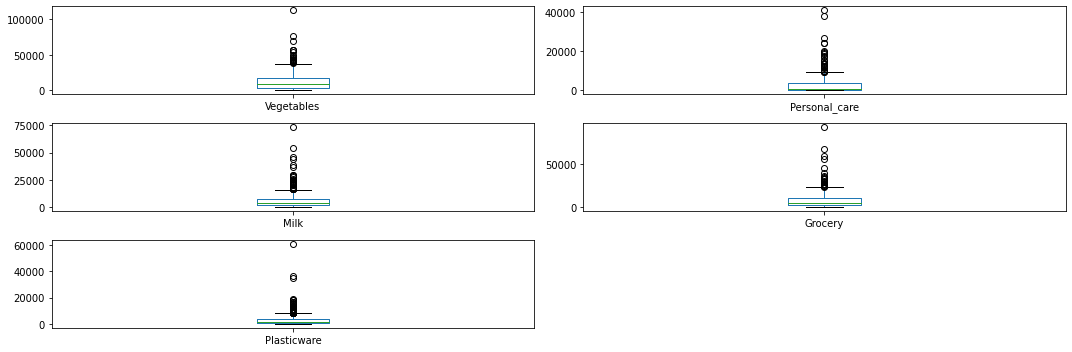

In [182]:
data.plot(kind='box',subplots=True,figsize=(15,5),layout=(3,2))
plt.tight_layout()
plt.show()

We can see that we have outliers and KMeans is effected by outliers.Hence we need to treat the outliers, we use capping method to treat the outliers.

In [183]:
for i in data.columns:
    Q1 = data[i].quantile(0.25)
    Q3 = data[i].quantile(0.75)
    IQR = Q3 - Q1
    lower_viscor = Q1 - (1.5 * IQR)
    upper_viscor = Q3 + (1.5 * IQR)
    lower_limit = data[i].quantile(0.01) # 1% value is used to cap values below lower_viscor
    upper_limit = data[i].quantile(0.99) # 99% value is used to cap values above upper_viscor
    for j in data[i].index:
        if (data[i][j] > upper_viscor):
            data[i][j] = upper_limit
        elif (data[i][j] < lower_viscor):
            data[i][j] = lower_limit

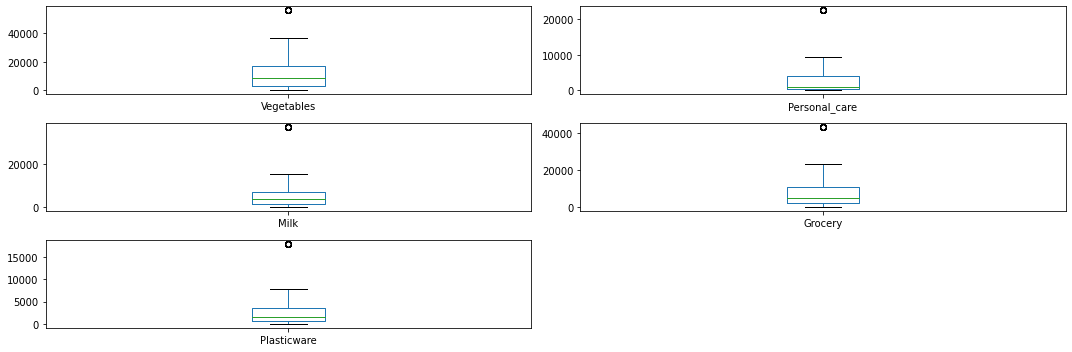

In [184]:
data.plot(kind='box',subplots=True,figsize=(15,5),layout=(3,2))
plt.tight_layout()
plt.show()

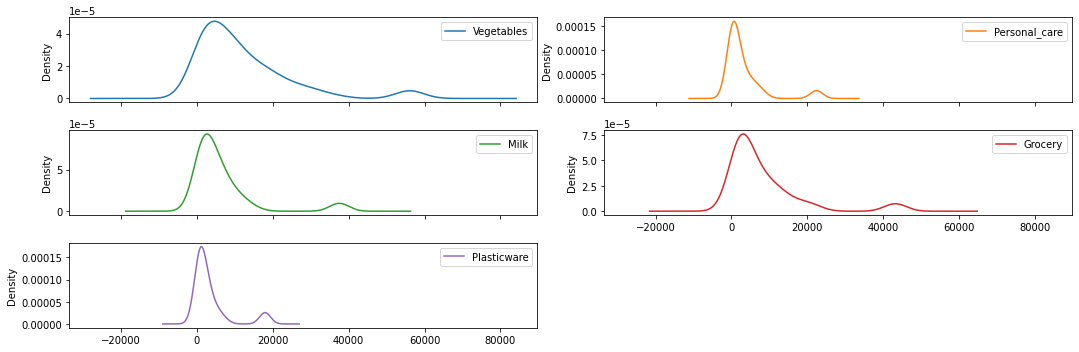

In [185]:
data.plot(kind='kde',subplots=True,figsize=(15,5),layout=(3,2))
plt.tight_layout()
plt.show()

All the values are skewed towards right.

#### Scaling

In [186]:
from sklearn.preprocessing import StandardScaler

In [187]:
ss = StandardScaler()
data_scale = pd.DataFrame(ss.fit_transform(data),columns=data.columns)
data_scale.head()

,Vegetables,Personal_care,Milk,Grocery,Plasticware
0,0.033606,-0.104767,0.375747,-0.070024,-0.648678
1,-0.406175,0.005471,0.393540,0.132603,-0.339284
2,-0.462000,0.045185,0.277766,-0.057606,-0.208918
3,0.079396,-0.490690,-0.601748,-0.407230,0.591902
4,0.813985,-0.264514,-0.114850,-0.106672,0.091465


#### Find optimal k value

In [188]:
from sklearn.cluster import KMeans

Find the optimal value of K using elbow plot

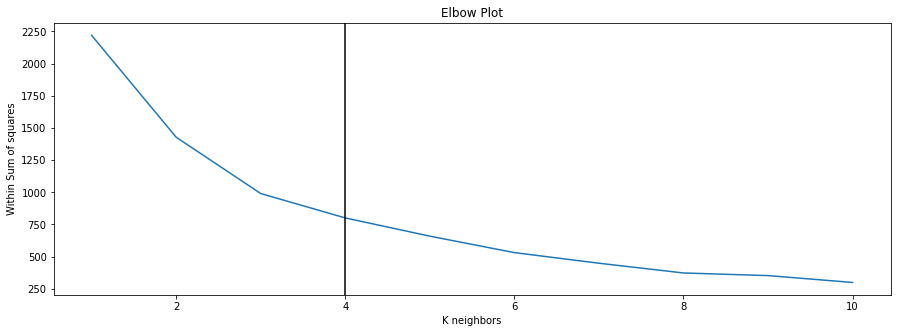

In [189]:
wss =[]
for i in range(1,11):
    model = KMeans(n_clusters=i,random_state=1)
    model.fit(data_scale)
    wss.append(model.inertia_)
plt.figure(figsize=(15,5))
plt.plot(range(1,11),wss)
plt.title('Elbow Plot')
plt.xlabel('K neighbors')
plt.ylabel('Within Sum of squares')
plt.axvline(4,c='black')
plt.show()

using elbow method k = 4 has optimal solution

Find optimal value using silhouette score

In [190]:
from sklearn.metrics import silhouette_samples,silhouette_score

In [191]:
sil_score = []
for k in range(2,11):
    model = KMeans(n_clusters=k, random_state=1)
    predict = model.fit_predict(data_scale)
    sil_score.append(silhouette_score(data_scale,predict))
sil_score

[0.612709485297954,
 0.5526081834432577,
 0.4685364335382418,
 0.3874092358686536,
 0.39470613431070534,
 0.4029138182259239,
 0.39476979357064845,
 0.33677749635675075,
 0.40737516704781374]

for k=2 we have max value for Silhouette score.

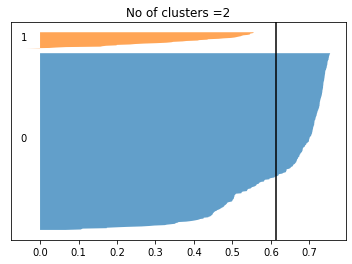

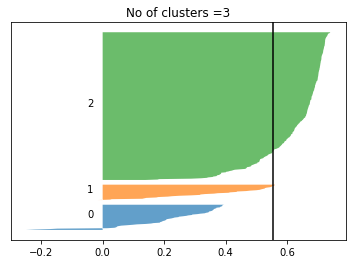

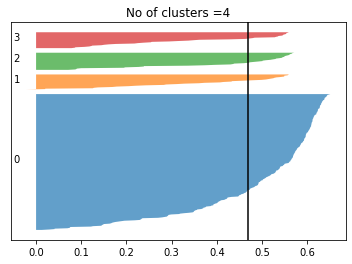

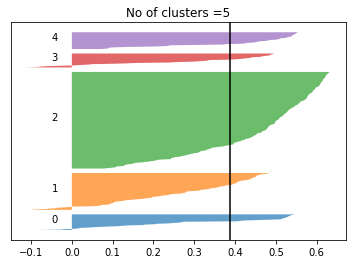

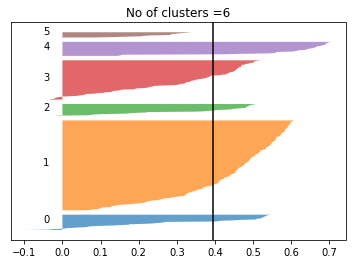

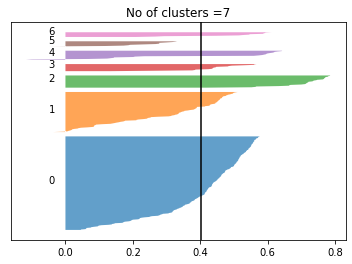

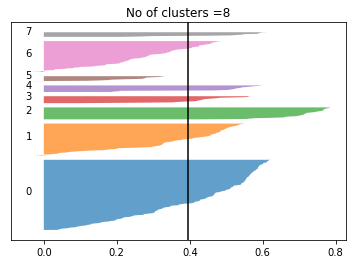

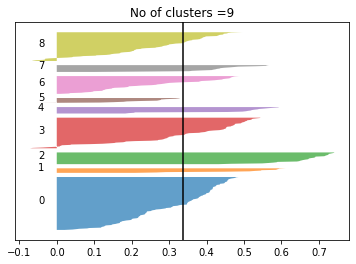

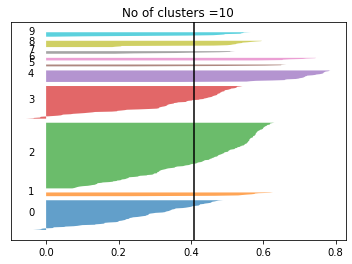

In [192]:
for k in range(2,11):
    model = KMeans(n_clusters=k, random_state=1)
    predict = model.fit_predict(data_scale)
    score = silhouette_score(data_scale,predict)
    samples = silhouette_samples(data_scale,predict)
    y_low = 10
    fig,ax = plt.subplots()
    for i in range(k):
        clusters = samples[predict==i]
        clusters.sort()
        cluster_size = clusters.shape[0]
        y_upper = y_low + cluster_size
        plt.fill_betweenx(np.arange(y_low,y_upper),0,clusters,alpha=0.7)
        
        plt.text(-0.05,y_low+(cluster_size/2),i)
        y_low = y_upper+10
    ax.set_yticks([])
    plt.title('No of clusters ='+ str(k))
    ax.axvline(score,c='black')
    plt.show()

from the above plot we can say that k=4 gives the optimal solution

#### Build model

In [193]:
model = KMeans(n_clusters=4,random_state=1)
model.fit(data_scale)

KMeans(n_clusters=4, random_state=1)

In [194]:
predict = model.labels_

In [195]:
df['Clusters'] = predict
df.head()

,Region,Vegetables,Personal_care,Milk,Grocery,Plasticware,Clusters
0,Rochester,12667,2674,9656,7561,212,0
1,Rochester,7058,3293,9810,9568,1757,0
2,Rochester,6346,3516,8808,7684,2408,0
3,Rochester,13251,507,1196,4221,6407,0
4,Rochester,22620,1777,5410,7198,3908,0


#### Profiling

In [196]:
df_prof = df.copy()

In [197]:
df_dummy = pd.get_dummies(df_prof['Region'])
df_dummy.head()

,Albany,Oneonta,Rochester
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [198]:
df_prof = df_prof.drop('Region',axis=1)
df_prof = pd.concat([df_dummy,df_prof],axis=1)
df_prof.head()

,Albany,Oneonta,Rochester,Vegetables,Personal_care,Milk,Grocery,Plasticware,Clusters
0,0,0,1,12667,2674,9656,7561,212,0
1,0,0,1,7058,3293,9810,9568,1757,0
2,0,0,1,6346,3516,8808,7684,2408,0
3,0,0,1,13251,507,1196,4221,6407,0
4,0,0,1,22620,1777,5410,7198,3908,0


In [199]:
df_prof.groupby('Clusters').agg('mean')

,Albany,Oneonta,Rochester,Vegetables,Personal_care,Milk,Grocery,Plasticware
Clusters,,,,,,,,
0,0.098160,0.184049,0.717791,8169.616564,2040.546012,4280.067485,5961.012270,1846.309816
1,0.189189,0.189189,0.621622,8425.594595,14695.027027,20205.810811,30431.000000,1844.351351
2,0.142857,0.095238,0.761905,24262.404762,742.428571,6424.261905,5480.071429,13861.523810
3,0.076923,0.205128,0.717949,34712.666667,867.384615,4369.615385,5268.384615,2765.615385


Cluster 0: 71% of retailers are from Rochester who are spending more on Vegetables and less on Plasticware.

Cluster 1: 62% of retailers are from Rochester who are spending more on Grocery and less on Plasticware.

Cluster 2: 76% of retailers are from Rochester who are spending more on Vegetables and less on Personal_care.

Cluster 3: 71% of retailers are from Rochester who are spending more on Grocery and less on Personal_care.

#### Visualization

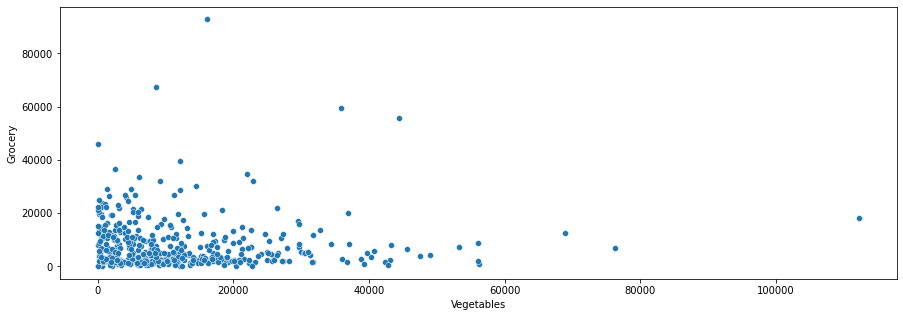

In [200]:
plt.figure(figsize=(15,5))
sns.scatterplot(df['Vegetables'],df['Grocery'])
plt.show()

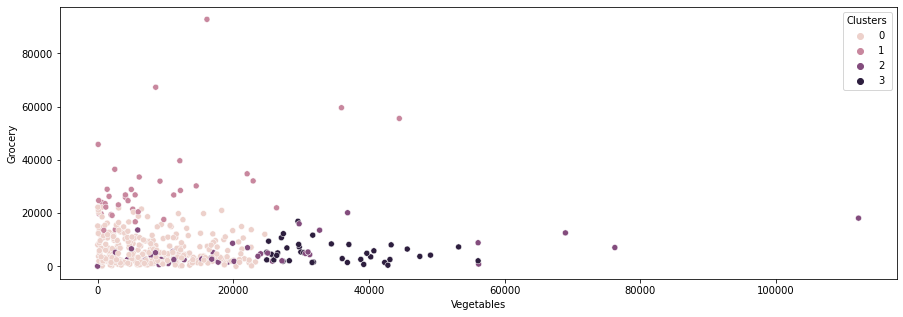

In [201]:
plt.figure(figsize=(15,5))
sns.scatterplot(df['Vegetables'],df['Grocery'],hue=df['Clusters'])
plt.show()

#### For more practice the same can be done for individual Regions.